In [2]:
# Import libraries. You may or may not use all of these.
%pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

Note: you may need to restart the kernel to use updated packages.


2023-07-30 02:03:18.610811: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-30 02:03:18.649010: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-30 02:03:18.942133: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-30 02:03:18.943737: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-30 02:03:20.208450: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [3]:
# Import data
from os.path import exists

if not exists("./insurance.csv"):
    !wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [4]:
"""
Investigate missing values
"""
dataset.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

In [5]:
"""
convert "smoker" column to numerical
"""
dataset.smoker = dataset.smoker.replace({"yes": 1, "no": 0})
dataset.smoker.value_counts()

smoker
0    1064
1     274
Name: count, dtype: int64

In [6]:
"""
convert "sex" column to numerical
"""
if "sex" in dataset.columns:
    dataset = dataset.rename(columns={"sex":"male"})
    dataset.male = dataset.male.replace({"male": 1, "female": 0})
dataset.head()

,age,male,bmi,children,smoker,region,expenses
0,19,0,27.9,0,1,southwest,16884.92
1,18,1,33.8,1,0,southeast,1725.55
2,28,1,33.0,3,0,southeast,4449.46
3,33,1,22.7,0,0,northwest,21984.47
4,32,1,28.9,0,0,northwest,3866.86


In [7]:
"""
convert "region" column to numerical hot-encoded columns
"""
if "region" in dataset.columns:
    dataset = pd.get_dummies(dataset, prefix="region", columns=["region"])

# convert boolean to numerical
dataset.region_northeast = dataset.region_northeast.replace({True: 1, False: 0})
dataset.region_northwest = dataset.region_northwest.replace({True: 1, False: 0})
dataset.region_southeast = dataset.region_southeast.replace({True: 1, False: 0})
dataset.region_southwest = dataset.region_southwest.replace({True: 1, False: 0})

dataset.head()

,age,male,bmi,children,smoker,expenses,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.9,0,1,16884.92,0,0,0,1
1,18,1,33.8,1,0,1725.55,0,0,1,0
2,28,1,33.0,3,0,4449.46,0,0,1,0
3,33,1,22.7,0,0,21984.47,0,1,0,0
4,32,1,28.9,0,0,3866.86,0,1,0,0


In [8]:
"""
Separating test data from data
"""
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(dataset, test_size=0.2)
train_dataset.head()

,age,male,bmi,children,smoker,expenses,region_northeast,region_northwest,region_southeast,region_southwest
892,54,1,24.0,0,0,10422.92,1,0,0,0
925,50,1,32.1,2,0,25333.33,1,0,0,0
1292,21,1,23.2,0,0,1515.34,0,0,1,0
305,29,1,33.3,2,0,19442.35,0,1,0,0
607,59,0,23.7,0,1,25678.78,0,1,0,0


In [9]:
"""
create labels
"""
train_labels = train_dataset.pop("expenses")
test_labels = test_dataset.pop("expenses")
train_labels

892     10422.92
925     25333.33
1292     1515.34
305     19442.35
607     25678.78
          ...   
108      2867.12
65       1743.21
567      7256.72
309      7749.16
400      9264.80
Name: expenses, Length: 1070, dtype: float64

In [10]:
"""
Ensure that the training data no longer has a label to predict
"""
train_dataset.head()

,age,male,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
892,54,1,24.0,0,0,1,0,0,0
925,50,1,32.1,2,0,1,0,0,0
1292,21,1,23.2,0,0,0,0,1,0
305,29,1,33.3,2,0,0,1,0,0
607,59,0,23.7,0,1,0,1,0,0


In [25]:
normalizer = tf.keras.layers.Normalization(axis=-1)

normalizer.adapt(np.array(train_dataset))

model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error',
    metrics=["mean_absolute_error", "mean_squared_error"]
)

history = model.fit(
    train_dataset,
    train_labels,
    epochs=7000,
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2
)

Epoch 1/7000
27/27 [==============================] - 0s 7ms/step - loss: 13346.4043 - mean_absolute_error: 13346.4043 - mean_squared_error: 324470528.0000 - val_loss: 13328.0869 - val_mean_absolute_error: 13328.0869 - val_mean_squared_error: 318629408.0000
Epoch 2/7000
27/27 [==============================] - 0s 4ms/step - loss: 13343.6748 - mean_absolute_error: 13343.6748 - mean_squared_error: 324397920.0000 - val_loss: 13325.4453 - val_mean_absolute_error: 13325.4453 - val_mean_squared_error: 318555744.0000
Epoch 3/7000
27/27 [==============================] - 0s 3ms/step - loss: 13340.9707 - mean_absolute_error: 13340.9707 - mean_squared_error: 324329600.0000 - val_loss: 13322.7871 - val_mean_absolute_error: 13322.7871 - val_mean_squared_error: 318489952.0000
Epoch 4/7000
27/27 [==============================] - 0s 4ms/step - loss: 13338.2568 - mean_absolute_error: 13338.2568 - mean_squared_error: 324262432.0000 - val_loss: 13320.1035 - val_mean_absolute_error: 13320.1035 - val_mea

9/9 - 0s - loss: 3405.6597 - mean_absolute_error: 3405.6597 - mean_squared_error: 47695836.0000 - 59ms/epoch - 7ms/step
Testing set Mean Abs Error: 3405.66 expenses
You passed the challenge. Great job!
9/9 [==============================] - 0s 2ms/step


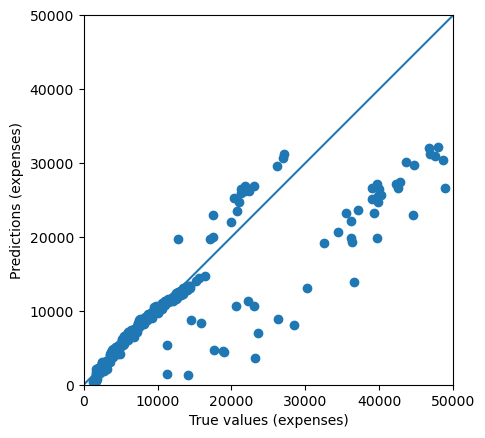

In [27]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
